## 04 Neural Networks with keras - 03 Genetic approach

In this notebook we implement an approach based on neural networks, using the library **keras** from **tensorflow** to predict whether the tweets refer to a real disaster or not. We establish a fixed architecture with two convolutional layers followed by a dense layer, and we tune the hyperparameters using a genetic approach.

#### Loading data

We start by importing the packages we are going to use and loading the datasets:

In [12]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import polyfit

import tensorflow as tf
import tensorflow.keras as keras

from keras.layers import TextVectorization
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dense

from sklearn.model_selection import KFold

import time

train_data = pd.read_csv("../../data/train.csv")
test_data = pd.read_csv("../../data/test.csv")

train_data['text'].replace('http:\/\/\S*', 'urltoken', regex=True, inplace=True)
test_data['text'].replace('http:\/\/\S*', 'urltoken', regex=True, inplace=True)

train_text, train_label = np.array(train_data['text']), np.array(train_data['target'])
test_text = test_data['text']

print(train_text.shape)
print(train_label.shape)
print(test_text.shape)

(7613,)
(7613,)
(3263,)


We explore the training data. There average tweet has 15 words, and the longest one has 31:

In [13]:
# Word counts
pd.Series(np.array([len(text.split()) for text in train_text])).describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
dtype: float64

There are 27736 unique words in all the tweets:

In [14]:
# Number of unique tokens among all tweets
len(np.unique(np.array(' '.join(train_text).split())))

27736

#### Model building

The following function will create and return a model with a fixed layer architecture whose hyperparameters are passed as a function parameter in the *params* dictionary.

We start with a **TextVectorization** layer with usual standardization, followed by an **Embedding** layer. We then compose with two **Conv1D** layers and perform **GlobalMaxPooling1D**, and finish with a **Dense** layer. We include some **Dropout** layers in order to avoid overfitting.

In [15]:
def build_model(params):
    dropout_rate = 0.5

    # Inputs are text strings, then we vectorize them
    inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')

    vectorizer = TextVectorization(
        standardize='lower_and_strip_punctuation',
        max_tokens=params['max_features'],
        output_mode="int",
        output_sequence_length=params['sequence_length'],
    )
    vectorizer.adapt(train_text)
    x = vectorizer(inputs)

    # We use Embedding to map the vectorized text onto a space of dimension embedding_dim
    x = Embedding(params['max_features'] + 1, params['embedding_dim'])(x)
    x = Dropout(dropout_rate)(x)

    # Conv1D + GlobalMaxPooling
    x = Conv1D(params['conv_1_filters'], params['conv_1_kernel_size'], strides=params['conv_1_strides'], activation='relu')(x)
    x = Conv1D(params['conv_2_filters'], params['conv_2_kernel_size'], strides=params['conv_2_strides'], activation='relu')(x)
    x = GlobalMaxPooling1D()(x)

    # Dense hidden layer
    x = Dense(params['dense_layer_size'], activation="relu")(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(1, activation="sigmoid", name="predictions")(x)

    model = keras.Model(inputs, outputs)

    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

    return model

#### Model training

The following function trains the given model for the specified number of epochs using the specified kfold cross-validation. As a result, we return the average score on the validation data over all folds:

In [16]:
def train(model, epochs, kfold):
    start = time.time()

    scores = []
    for fold_train_indices, fold_val_indices in kfold.split(train_text, train_label):
        fold_train_text = train_text[fold_train_indices]
        fold_train_label = train_label[fold_train_indices]
        fold_val_text = train_text[fold_val_indices]
        fold_val_label = train_label[fold_val_indices]

        model.fit(fold_train_text, fold_train_label, epochs=epochs, verbose=0)
        fold_val_score = model.evaluate(fold_val_text, fold_val_label)
        scores.append(fold_val_score)

    score = np.mean(scores)

    print(">>> Score:", round(score, 4))
    print(">>> Time:", round(time.time() - start, 2), "s")

    return score

#### Genetic algorithms

We are now ready to set up the genetic approach, with which we expect to tune the hyperparameters of the models. We do so by defining operations to combine and mutate the models, and simulate each generation with an approach based on natural selection, with better-performing models having more chances of having offspring than worse-performing ones.

The following function takes a *genotype* (just a dictionary of the hyperparameters of a model) and *mutates* it by slightly perturbing its values. More details in the inline comments. The function also clamps *sequence_length* and *max_features* to reasonable maxima, and corrects some hyperparameters from the convolutional layers in order to avoid unfeasible models.

In [17]:
def mutate(genotype):
    for param in genotype.keys():
        # Random number r = 1 + |N(0, 0.2)|, we ensure r >= 1 and typically r < 1.5
        r = 1 + np.abs(np.random.normal(0, 0.2))
        # We decide at random with equal probability whether we take r or 1/r
        perturbed_value = round(np.random.choice([genotype[param] * r, genotype[param] / r]))
        genotype[param] = np.max([1, perturbed_value])

    # Hard-coded maxima
    genotype['sequence_length'] = np.min([32, genotype['sequence_length']])
    genotype['max_features'] = np.min([30000, genotype['max_features']])

    # Fix unfeasible genotypes
    input_size_conv_1 = genotype['sequence_length']
    genotype['conv_1_kernel_size'] = np.min([input_size_conv_1, genotype['conv_1_kernel_size']])

    input_size_conv_2 = math.floor((input_size_conv_1 - (genotype['conv_1_kernel_size'] - genotype['conv_1_strides'])) / genotype['conv_1_strides'])
    genotype['conv_2_kernel_size'] = np.min([input_size_conv_2, genotype['conv_2_kernel_size']])

    # Convert numpy.int64 to int
    for param in genotype.keys():
        genotype[param] = genotype[param].item()

    return genotype

The following function takes two genotypes and combines them by averaging all the parameters and mutating the resulting genotype with the *mutate* function:

In [18]:
def reproduce(genotype_1, genotype_2):
    genotype = {}
    for param in params.keys():
        genotype[param] = round(np.mean([genotype_1[param], genotype_2[param]]))

    return mutate(genotype)

This is just a helper function used to print the genotype of a model:

In [19]:
def print_genotype(genotype):
    s = str(genotype['max_features']) + ' '
    s += str(genotype['sequence_length']) + ' '
    s += str(genotype['embedding_dim']) + ' '
    s += str(genotype['conv_1_filters']) + '-' + str(genotype['conv_1_kernel_size']) + '-' + str(genotype['conv_1_strides']) + ' '
    s += str(genotype['conv_2_filters']) + '-' + str(genotype['conv_2_kernel_size']) + '-' + str(genotype['conv_2_strides']) + ' '
    s += str(genotype['dense_layer_size'])
    print(s)

The following function simulates one generation for a population of models, represented by their genotypes, by doing two things:
1. Generates the following generation of genotypes, by choosing parents and reproducing them, with uneven probabilities so that better-performing models are more likely to be chosen.
2. Trains all resulting models using cross-validation and obtaining a score for each of them. This score allows to sort them by performance and both the models' genotypes and scores are returned.


**Assumption**: The *population* list contains the genotypes in descending order of score.

In [20]:
def generation(population, epochs):
    n = len(population)
    probabilities = np.linspace(1.9, 0.1, n) / n

    children = []
    for i in range(n):
        parents = np.random.choice(population, p=probabilities, size=2, replace=False)
        child = reproduce(parents[0], parents[1])
        children.append(child)

    population = children

    kfold = KFold(n_splits=3, shuffle=True)

    scores = []
    for genotype in population:
        print("> Model", len(scores), end=": ")
        print_genotype(genotype)
        try:
            model = build_model(genotype)
            score = train(model, epochs, kfold)
        except:
            score = 0
        scores.append(score)
        print()

    sorted_tuples = sorted(zip(scores, population), reverse=True)
    return {
        'population': [genotype for _, genotype in sorted_tuples],
        'scores': [score for score, _ in sorted_tuples]
    }

These are the parameters with which the models of the first generation will start:

In [21]:
# Initial params for experiment 1
params = {
    'max_features': 10000,
    'sequence_length': 32,
    'embedding_dim': 32,
    'conv_1_filters': 32,
    'conv_1_kernel_size': 3,
    'conv_1_strides': 1,
    'conv_2_filters': 32,
    'conv_2_kernel_size': 3,
    'conv_2_strides': 1,
    'dense_layer_size': 32
}

# Initial params for experiment 2
params = {
    'max_features': 25000,
    'sequence_length': 20,
    'embedding_dim': 64,
    'conv_1_filters': 30,
    'conv_1_kernel_size': 4,
    'conv_1_strides': 2,
    'conv_2_filters': 54,
    'conv_2_kernel_size': 4,
    'conv_2_strides': 2,
    'dense_layer_size': 36
}

# Initial params for experiment 3
params = {
    'max_features': 20000,
    'sequence_length': 21,
    'embedding_dim': 90,
    'conv_1_filters': 38,
    'conv_1_kernel_size': 4,
    'conv_1_strides': 2,
    'conv_2_filters': 84,
    'conv_2_kernel_size': 4,
    'conv_2_strides': 2,
    'dense_layer_size': 41
}

This is now the main code which starts the genetic simulation. We initialize the models in the first generation with the hard-coded values in *params*, and set the number of generations, the size of the population for each generation, and the number of epochs to train each model.

We then iterate and simulate each generation sequentially, with each population being the offspring of the previous one.

In [ ]:
n_generations = 40
population_size = 20
epochs = 3

start = time.time()

all_populations = []
all_scores = []

population = [params] * population_size

for i in range(n_generations):
    print('*'*20, "Generation", i, '*'*20)

    generation_results = generation(population, epochs)
    population = generation_results['population']
    scores = generation_results['scores']

    all_populations.append(population)
    all_scores.append(scores)

    print('> Average generation score:', round(np.mean(scores), 4))


print("Total time:", round(time.time() - start, 2), "s")

#### Results

We are now ready to look at the results of the execution. We start by storing them into a pickle file:

In [53]:
import pickle

exp_data = {
    'all_populations': all_populations,
    'all_scores': all_scores
}

f = open('exp-data.pckl', 'wb')
pickle.dump(exp_data, f)
f.close()

We can check the average of the hyperparameters of the last generation of models, to see if they have evolved significantly:

In [66]:
for param in params.keys():
    print(param, round(np.mean([genotype[param] for genotype in population])), "(", params[param], ")")

max_features 23298 ( 20000 )
sequence_length 24 ( 21 )
embedding_dim 346 ( 90 )
conv_1_filters 58 ( 38 )
conv_1_kernel_size 10 ( 4 )
conv_1_strides 2 ( 2 )
conv_2_filters 128 ( 84 )
conv_2_kernel_size 4 ( 4 )
conv_2_strides 2 ( 2 )
dense_layer_size 85 ( 41 )


We plot the average and max score of each generation:

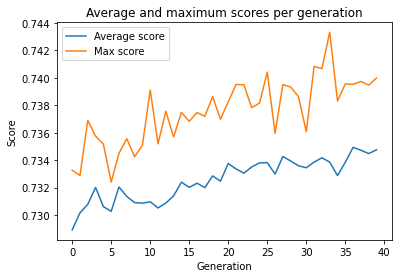

In [56]:
generation_average_scores = np.mean(all_scores, axis=1)
generation_max_scores = np.max(all_scores, axis=1)

fig, ax = plt.subplots()
ax.plot(generation_average_scores, color='tab:blue', label='Average score')
ax.plot(generation_max_scores, color='tab:orange', label='Max score')
ax.set_xlabel('Generation')
ax.set_ylabel('Score')
ax.set_title('Average and maximum scores per generation')
ax.legend()

We can also plot the evolution of each hyperparameter over all generations:

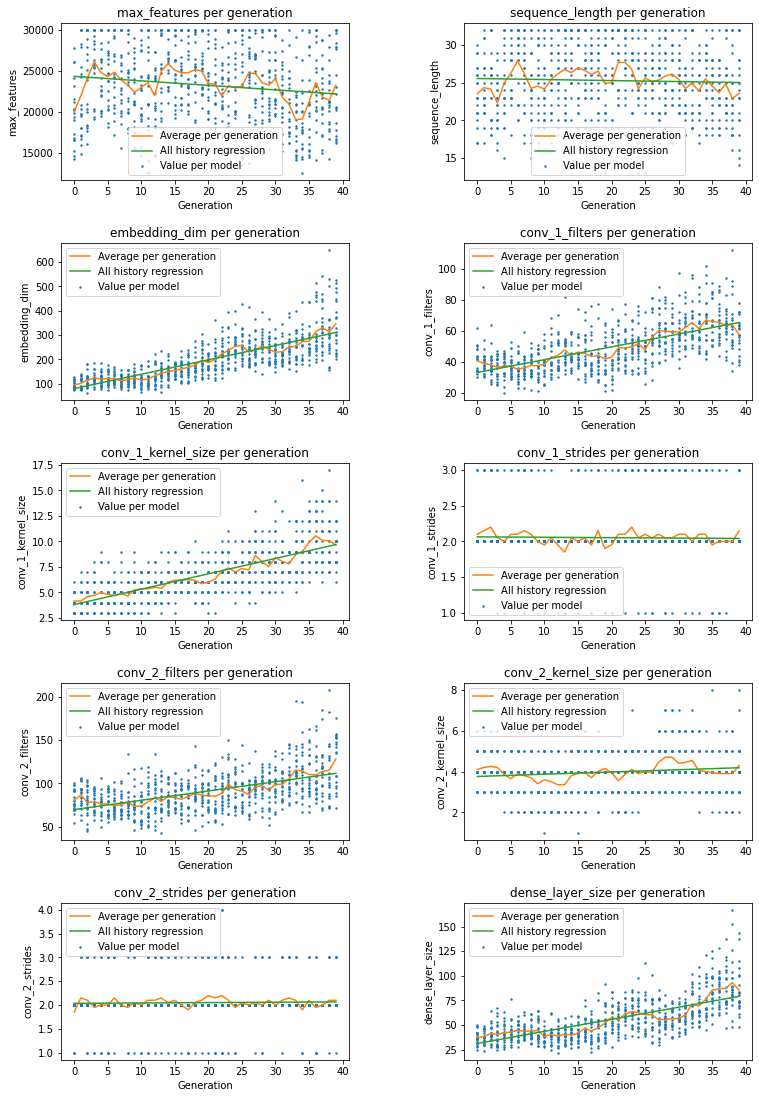

In [57]:
x = np.array([i for i in range(n_generations) for j in range(population_size)])

fig, axs = plt.subplots(5, 2, figsize=(12, 18))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
axs = axs.ravel()

i = 0
for param in params.keys():
    y = np.array([genotype[param] for population in all_populations for genotype in population])
    mean_x = np.array(range(n_generations))
    mean_y = np.array([np.mean([genotype[param] for genotype in population]) for population in all_populations])
    b, m = polyfit(x, y, deg=1)

    axs[i].scatter(x, y, s=2, color='tab:blue', label='Value per model')
    axs[i].plot(mean_x, mean_y, color='tab:orange', label='Average per generation')
    axs[i].plot(x, m * x + b, color='tab:green', label='All history regression')
    axs[i].set_xlabel('Generation')
    axs[i].set_ylabel(param)
    axs[i].set_title(param + ' per generation')
    axs[i].legend()
    i += 1

#### Submission

We finally take the best-performing model of the last generation and train it with all the available data:

In [58]:
best_genotype = population[0]
model = build_model(best_genotype)
model.fit(train_text, train_label, epochs=3, verbose=2)

model.evaluate(train_text, train_label, verbose=2)

Epoch 1/3
238/238 - 44s - loss: 0.5745 - accuracy: 0.6917 - precision_800: 0.7406 - recall_800: 0.4347
Epoch 2/3
238/238 - 42s - loss: 0.3184 - accuracy: 0.8765 - precision_800: 0.8947 - recall_800: 0.8077
Epoch 3/3
238/238 - 42s - loss: 0.1413 - accuracy: 0.9515 - precision_800: 0.9583 - recall_800: 0.9275
238/238 - 2s - loss: 0.0623 - accuracy: 0.9799 - precision_800: 0.9848 - recall_800: 0.9682


[0.06232769042253494,
 0.9799028038978577,
 0.9847636818885803,
 0.968205451965332]

We generate the predictions for the test set:

In [59]:
test_pred = model.predict(test_text)
test_pred = np.round(test_pred).flatten().astype('int')

test_pred

array([1, 1, 1, ..., 1, 1, 1])

And we save the predictions into a csv file ready for submission:

In [60]:
output = pd.DataFrame({'id': test_data['id'], 'target': test_pred})
output.to_csv('predictions/nnets.csv', index=False)
print("Submission successfully saved!")

Submission successfully saved!
